In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2
import tensorflow as tf
plt.style.use('seaborn')

### Loading the Saved Models

In [16]:
model = load_model('./drive/My Drive/Assistive Vision/features/model.h5')
feature_extractor = load_model("./drive/My Drive/Assistive Vision/features/feature_extractor.h5")
with open('./drive/My Drive/Assistive Vision/features/word2idx.pkl', 'rb') as f:
  word2idx = pickle.load(f)
with open('./drive/My Drive/Assistive Vision/features/idx2word.pkl', 'rb') as f:
  idx2word = pickle.load(f)

### Greedy Sampling

In [0]:
max_len = 74
def predict_captions(img):
    start_word = ["<BEGIN>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encode_image(img)
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        if word_pred == "<END>" or len(start_word) > max_len:
            break
    return ' '.join(start_word[1:-1])

### Beam Search

In [0]:
def beam_search_predictions(img, beam_index = 3):
    start = [word2idx["<BEGIN>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encode_image(img)
            preds = model.predict([np.array([e]), np.array(par_caps)])
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]
    final_caption = []
    for i in intermediate_caption:
        if i != '<END>':
            final_caption.append(i)
        else:
            break
    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Image Feature Extraction

In [0]:
def encode_image(img):
    img = image.load_img(img,target_size=(299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    feature_vector = feature_extractor.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

### Validation on Sample Data

Saving 44856031_0d82c2c7d1.jpg to 44856031_0d82c2c7d1 (2).jpg
Saving 47870024_73a4481f7d.jpg to 47870024_73a4481f7d (2).jpg
Saving 47871819_db55ac4699.jpg to 47871819_db55ac4699 (2).jpg
Saving 54501196_a9ac9d66f2.jpg to 54501196_a9ac9d66f2 (1).jpg
Saving 55470226_52ff517151.jpg to 55470226_52ff517151 (1).jpg
Saving 69189650_6687da7280.jpg to 69189650_6687da7280.jpg


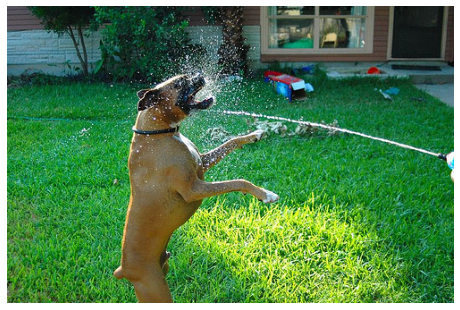

Greedy Sampling :  dog running on the beach
Beam Search, k=3 :  brown dog is running through the grass
Beam Search, k=5 :  brown dog is running through the grass
Beam Search, k=7 :  white dog is running through the grass


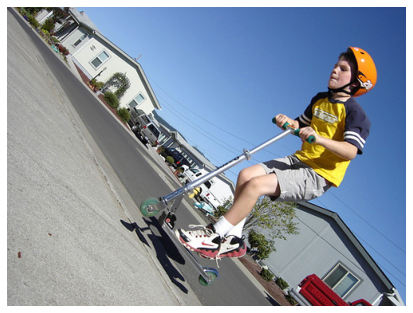

Greedy Sampling :  skateboarder is performing trick on his skateboard
Beam Search, k=3 :  man in blue shirt and jeans is skateboarding on the street
Beam Search, k=5 :  shirtless man in blue shirt and jeans is working on his skateboard in the middle of skate park
Beam Search, k=7 :  shirtless man in blue shirt and jeans is working on his skateboard in the middle of skate park


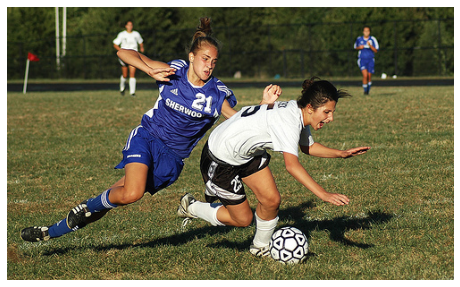

Greedy Sampling :  two men playing soccer on field
Beam Search, k=3 :  two boys playing soccer on the field
Beam Search, k=5 :  two boys playing soccer on the field
Beam Search, k=7 :  two boys playing soccer on the field


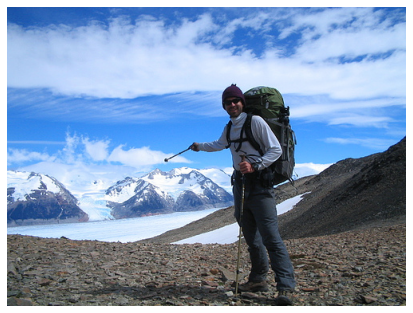

Greedy Sampling :  man in blue shirt and jeans is standing on the beach with mountains in the background
Beam Search, k=3 :  man in blue shirt is standing on top of the sand with mountains in the background
Beam Search, k=5 :  man is standing on the side of the sand with mountains in the background
Beam Search, k=7 :  man is standing on top of snow covered mountain


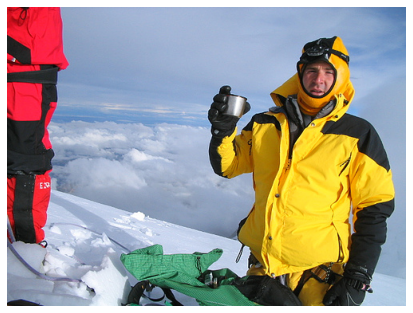

Greedy Sampling :  two people in winter gear are shoveling snow
Beam Search, k=3 :  young boy in red jacket and helmet is shoveling snow in the snow
Beam Search, k=5 :  young boy in red jacket and helmet is shoveling snow in the snow
Beam Search, k=7 :  group of people dressed in winter clothing and hard hats are standing in the snow next to ski


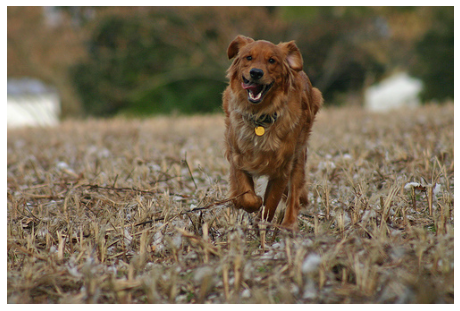

Greedy Sampling :  brown dog runs through the water
Beam Search, k=3 :  brown dog is running through the water
Beam Search, k=5 :  brown dog is running through the snow
Beam Search, k=7 :  brown dog is running through the snow


In [20]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  img = cv2.imread(path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.axis('off')
  plt.imshow(img)
  plt.show()
  print ('Greedy Sampling : ', predict_captions(path)) 
  print ('Beam Search, k=3 : ', beam_search_predictions(path, beam_index=3))
  print ('Beam Search, k=5 : ', beam_search_predictions(path, beam_index=5))
  print ('Beam Search, k=7 : ', beam_search_predictions(path, beam_index=7))